In [1]:
# Install required libraries
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.7 MB/s eta 0:00:00


In [2]:
# Import required libraries
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [3]:
grid = np.zeros((3,3)) #this is how you define a 3x3 grid
print(grid)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


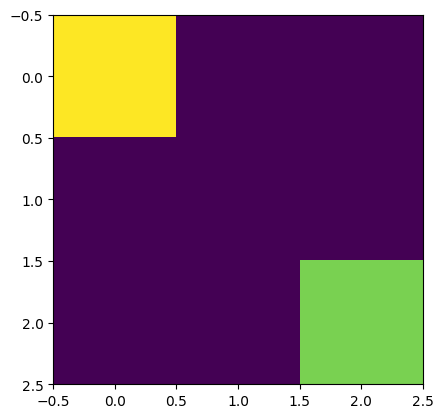

In [4]:
pos1 = [0,0] #start position of our agent
pos2 = [2,2] #goal position of our agent
grid[tuple(pos1)] = 1
grid[tuple(pos2)] = 0.8

plt.imshow(grid)

In [5]:
# Definition of the Grid Environment class.

class GridEnvironment(gym.Env):
    # Attribute of a Gym class that provides info about the render modes
    metadata = { 'render.modes': [] }

    # Initialization function
    def __init__(self):

      self.environment_width = 5
      self.environment_height = 5

      self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
      self.action_space = spaces.Discrete(4)
      self.max_timesteps = 10

      self.timestep = 0
      self.agent_pos = [4, 0]
      self.goal_pos = [1, 3]
      self.battery_pos = [1, 0]
      self.super_battery_pos = [1, 2]
      self.rock1_pos = [4, 2]
      self.rock2_pos = [3, 3]
      self.battery_quantity = 1
      self.super_battery_quantity = 1
      self.rock1_quantity = 1
      self.rock2_quantity = 1
      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.battery_pos)] = 2
      self.state[tuple(self.super_battery_pos)] = 3
      self.state[tuple(self.rock1_pos)] = 4
      self.state[tuple(self.rock2_pos)] = 4
      self.state[tuple(self.goal_pos)] = 5

    # Reset function
    def reset(self, **kwargs):
      self.timestep = 0
      self.agent_pos = [4, 0]
      self.goal_pos = [1, 3]
      self.battery_pos = [1, 0]
      self.super_battery_pos = [1, 2]
      self.rock1_pos = [4, 2]
      self.rock2_pos = [3, 3]
      self.battery_quantity = 1
      self.super_battery_quantity = 1
      self.rock1_quantity = 1
      self.rock2_quantity = 1
      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.battery_pos)] = 2
      self.state[tuple(self.super_battery_pos)] = 3
      self.state[tuple(self.rock1_pos)] = 4
      self.state[tuple(self.rock2_pos)] = 4
      self.state[tuple(self.goal_pos)] = 5
      observation = self.state.flatten()

      info = {}

      return observation, info

    # Step function: Contains the implementation for what happens when an
    # agent takes a step in the environment.
    def step(self, action):

      if action == 0: #down
        self.agent_pos[0] += 1
      if action == 1: #up
        self.agent_pos[0] -= 1
      if action == 2: #right
        self.agent_pos[1] += 1
      if action == 3: #left
        self.agent_pos[1] -= 1

      # Comment this to demonstrate the truncation condition.
      #self.agent_pos = np.clip(self.agent_pos, 0, 4)

      reward = 0

      # Condition to check if agent is traversing to a cell beyond the permitted cells
      # This helps the agent to learn how to behave in a safe and predictable manner
      truncated = False if np.all((np.asarray(self.agent_pos) >= 0 ) & (np.asarray(self.agent_pos) <= 4)) else True

      if truncated:
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        reward -= 100

      self.state = np.zeros((5,5))
      self.state[tuple(self.agent_pos)] = 1
      if (self.battery_quantity > 0):
        if np.array_equal(self.agent_pos, self.battery_pos):
          self.state[tuple(self.battery_pos)] = 1
        else:
          self.state[tuple(self.battery_pos)] = 2
      if (self.super_battery_quantity > 0) :
        if np.array_equal(self.agent_pos, self.super_battery_pos):
          self.state[tuple(self.super_battery_pos)] = 1
        else:
          self.state[tuple(self.super_battery_pos)] = 3
      if (self.rock1_quantity > 0) :
        if np.array_equal(self.agent_pos, self.rock1_pos):
          self.state[tuple(self.rock1_pos)] = 1
        else:
          self.state[tuple(self.rock1_pos)] = 4
      if (self.rock2_quantity > 0) :
        if np.array_equal(self.agent_pos, self.rock2_pos):
          self.state[tuple(self.rock2_pos)] = 1
        else:
          self.state[tuple(self.rock2_pos)] = 4
      if np.array_equal(self.agent_pos, self.goal_pos):
        self.state[tuple(self.goal_pos)] = 1
      else:
        self.state[tuple(self.goal_pos)] = 5
      observation = self.state.flatten()

      if np.array_equal(self.agent_pos, self.goal_pos):
        reward += 100
      if np.array_equal(self.agent_pos, self.battery_pos) and (self.battery_quantity > 0):
        reward += 3
        self.battery_quantity -= 1
      if np.array_equal(self.agent_pos, self.super_battery_pos) and (self.super_battery_quantity > 0):
        reward += 5
        self.super_battery_quantity -= 1
      if np.array_equal(self.agent_pos, self.rock1_pos) and (self.rock1_quantity > 0):
        reward -= 5
        self.rock1_quantity -= 1
      if np.array_equal(self.agent_pos, self.rock2_pos) and (self.rock2_quantity > 0):
        reward -= 5
        self.rock2_quantity -= 1

      self.timestep += 1

      # Condition to check for termination (episode is over)
      terminated = True if (self.timestep >= self.max_timesteps) or (np.array_equal(self.agent_pos, self.goal_pos)) else False

      info = {}

      return observation, reward, terminated, truncated, info

    # Render function: Visualizes the environment
    def render(self, plot=False):
      plt.title('Grid Environment')
      plt.imshow(self.state)

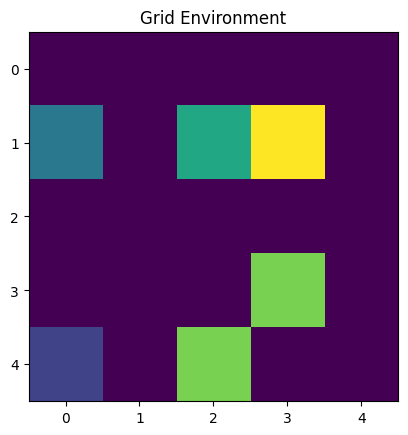

In [6]:
env = GridEnvironment()

terminated, truncated = False, False
obs, info = env.reset()
env.render()


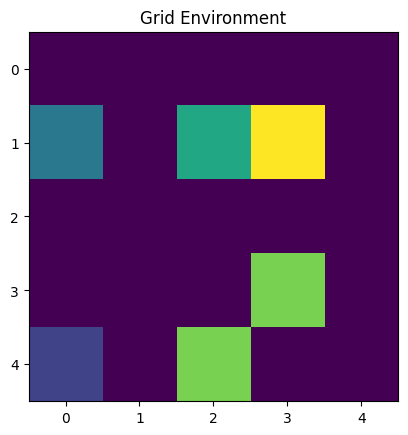

In [7]:
action = 0
observation, reward, done, truncated, info = env.step(action)
env.render()

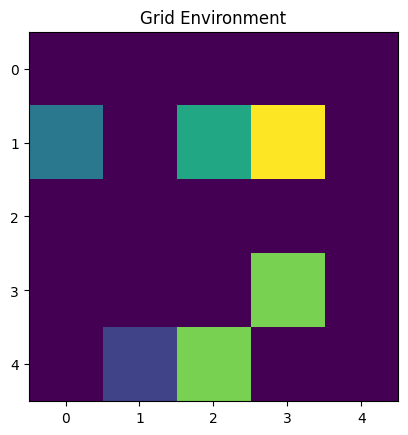

In [8]:
action = 2
observation, reward, done, truncated, info = env.step(action)
env.render()

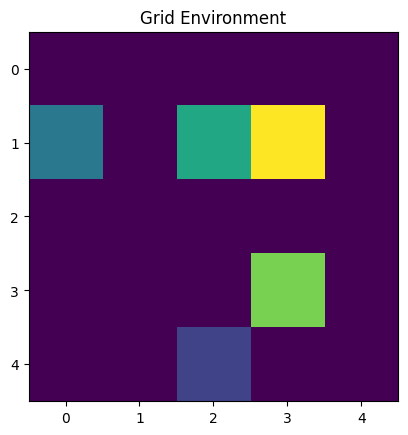

In [9]:
action = 2
observation, reward, done, truncated, info = env.step(action)
env.render()

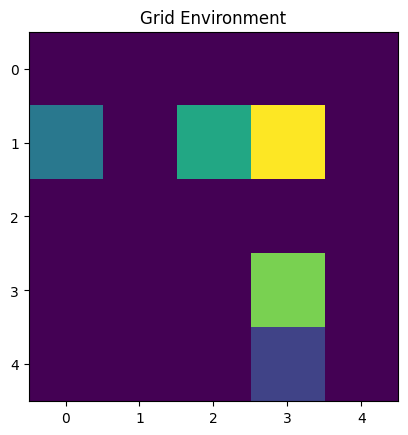

In [10]:
action = 2
observation, reward, done, truncated, info = env.step(action)
env.render()

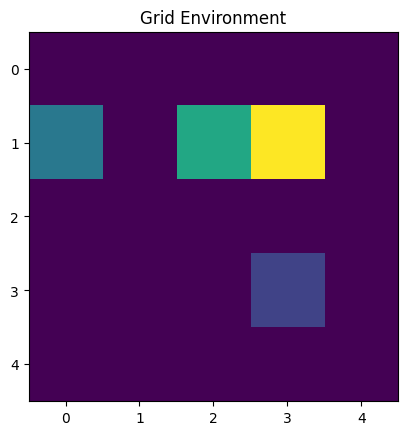

In [12]:
action = 1
observation, reward, done, truncated, info = env.step(action)
env.render()

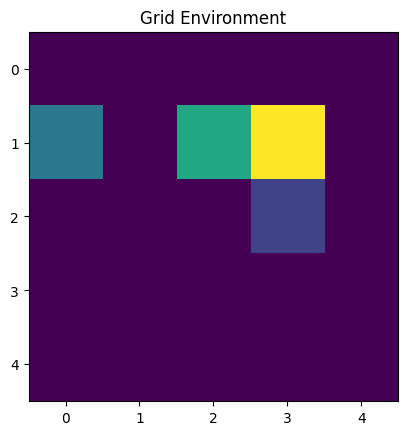

In [13]:
action = 1
observation, reward, done, truncated, info = env.step(action)
env.render()

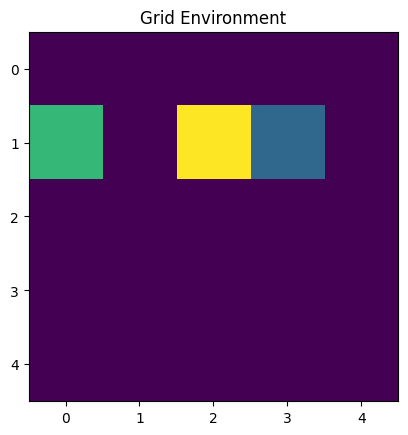

In [14]:
action = 1
observation, reward, done, truncated, info = env.step(action)
env.render()

In [15]:
# Definition an agent that takes action randomly
class RandomAgent:

  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    """Takes a step in the environment by choosing an action randomly.

    Args:
        obs: The current observation.

    Returns:
        The action to take.
    """
    return np.random.choice(self.action_space.n)

Action: 0 , Reward: -100 , Done: False
Action: 1 , Reward: 0 , Done: False
Action: 0 , Reward: 0 , Done: False
Action: 3 , Reward: -100 , Done: False
Action: 1 , Reward: 0 , Done: False
Action: 0 , Reward: 0 , Done: False
Action: 2 , Reward: 0 , Done: False
Action: 2 , Reward: -5 , Done: False
Action: 1 , Reward: 0 , Done: False
Action: 3 , Reward: 0 , Done: True


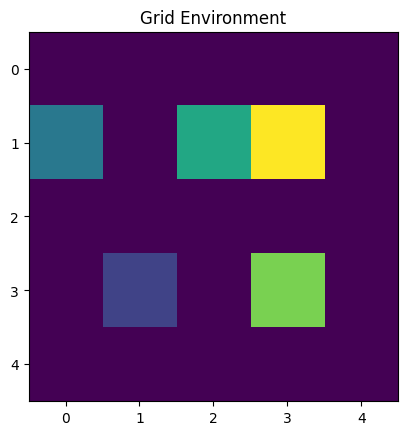

In [18]:
# Sample code for environment and agent implementation. Also shows
# visualization of the random agent's movement across the grid. The yellow cell
# shows the movement of the agent.

if __name__ == '__main__':
  env = GridEnvironment()
  agent = RandomAgent(env)

  obs, info = env.reset()
  terminated, truncated = False, False

  while not terminated:
    action = agent.step(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print('Action:', action, ', Reward:', reward, ', Done:', terminated)
    env.render()